In [6]:
#implementing a simple auto gradient calculator which can be then used in backprop, rough work done
#here, great for learning

In [7]:
import math
import numpy as np  #type: ignore
import matplotlib.pyplot as plt  #type: ignore
%matplotlib inline
#type: ignore is used to suppress type checking error from tools like mypy

25.0
16.000300000058587


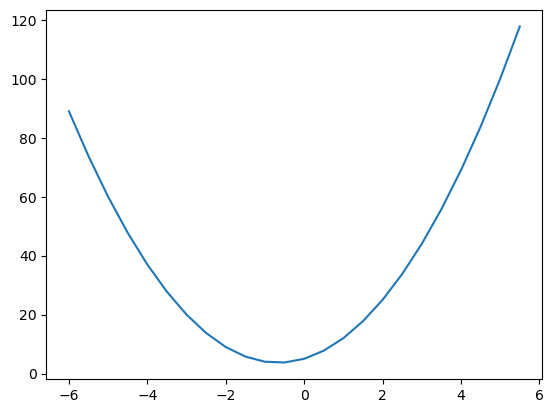

In [8]:
#simple single variable egs where limit definition is used to find the derivative 
def f(x: float)->float:
    return 3*x**2 + 4*x + 5

print(f(2.0))

h = 0.0001  #make it tend to zero
a = 2.0
df_dx_pt = (f(a+h) - f(a))/h  #derivative at x = a, based on the limit definition
print(df_dx_pt)

xs = np.arange(-6, 6, 0.5)
ys = f(xs)  #np will apply the f() function to each of the vals of the xs array
plt.plot(xs, ys)

In [9]:
#multivariate case
def g(a: float, b: float, c: float) -> float:
    return a*b + c
 
a = 2.0
b = -3.0
c = 10.0
print(g(a, b, c))

h = 0.00001
dg_da_pt = (g(a+h, b, c) - g(a, b, c))/h   #del g by del a at those points specified 
print(dg_da_pt)

4.0
-3.000000000064062


In [34]:
#now implementing some functionalities of the micrograd code
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)  #done for efficiency
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None  #the base case
    
    def __repr__(self):
        return f"(data: {self.data}, operation: {self._op}, label: {self.label})"
    
    def __add__(self, other):  #other is another Value instance 
        other = other if isinstance(other, Value) else Value(other)  #so that we can add ints, floats etc 
        out = Value(self.data + other.data, (self, other), '+')   #returns back another Value instance

        def _backward():  #a func to setup the gradients of the child nodes of the outputted label node
            self.grad += out.grad   #+= used in both the cases to handle the multivariate case
            #where one label is used more than once 
            other.grad += out.grad
        
        self._backward = _backward
        return out
    
    def __radd__(self, other):  #is a fallback for __add__ where if the first obj is not Value type
        #then it falls back to this function where self becomes the right ele and not the left one,
        #and this internal swapping is done by python 
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return (self) + (-other)
    
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)  #so that we can add ints, floats etc 

        out = Value(self.data * other.data, (self, other), '*')     

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        self._backward = _backward
        return out
    
    def __rmul__(self, other):  #is a fallback for __mul__ function
        return self * other 
    
    def tanh(self):
        t = ((math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1))
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        self._backward = _backward
        return out
    

    def exp(self):
        e = math.exp(self.data)
        out = Value(e, (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad  #as out.data is just e^x which is the local gradient
            #and out.grad is the global gradient wrt this node required to have the effect of the 
            #gradients of the forward nodes
        
        self._backward = _backward
        return out

    def __pow__(self,other): 
        assert isinstance(other, (int, float))  #only letting the power be int or float for now
        p = self.data**other
        out = Value(p, (self, ), 'pow')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
            other += (p)*(math.log(p))

        self._backward = _backward
        return out 
    
    def __truediv__(self, other):  #to handle division 
        return self * other**-1   #here onlt self, other is used directly which means that __mul__
        #and __pow__ funcs of the class are called
    
    def backward_prop(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for children_v in v._prev:
                    build_topo(children_v)
                topo.append(v)
        build_topo(self)  #calling it 

        self.grad = 1  #init value
        for node in range(len(topo)-1, -1, -1):
            topo[node]._backward()


In [11]:
a = Value(2, label='a')
b = Value(3, label='b')
c = Value(4, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2, label='f')
L = e*f; L.label='L'
#mentioning all the variables in the format having only one operator

print(L._prev)  #calling the prev values which led to c, which were the values of a and b
print(L._op)  #the outer most operation which led to c

{(data: 10, operation: +, label: e), (data: -2, operation: , label: f)}
*


In [12]:
#using graphviz to draw the graph 
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        #creating a value node for it
        if n._op:
            dot.node(name = uid + n._op, label = n._op)  #creating op nodes which are more like
            #fake nodes
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [13]:
#first up, finding the gradients by hand

def grad_finder_manual():
    h = 0.001
    a = Value(2, label='a')
    b = Value(3, label='b')
    c = Value(4, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2, label='f')
    L = e*f; L.label='L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(3, label='b')
    c = Value(4, label='c')
    d = a*b; d.label = 'd'
    d.data += h
    e = d + c; e.label = 'e'
    f = Value(-2, label='f')
    L = e*f; L.label='L'
    L2 = L.data

    L.grad = 1
    e.grad = f.data
    f.grad = e.data
    d.grad = (L2-L1)/h

    d.data -= h #back to first state
    c.data += h
    c.grad = (L2-L1)/h
    c.data -= h
    a.data += h
    a.grad += (L2-L1)/h
    a.data -= h
    b.data += h
    b.grad += (L2-L1)/h
    b.data -= h

    return (e.grad, f.grad, d.grad, c.grad, a.grad, b.grad)


e.grad, f.grad, d.grad, c.grad, a.grad, b.grad = grad_finder_manual()

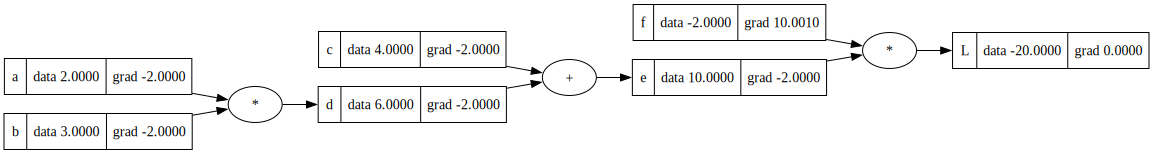

In [14]:
draw_dot(L)  #from the graph we can see the neuron image come into life slowly

another egs pertaining to having a neuron

In [15]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'



In [16]:
o.grad = 1
n.grad = 1 - o.data**2  #as derivative of tanhx is 1 - tanhx**2, also here n.grad means do/dn
x1w1x2w2.grad = b.grad = n.grad #as the op node here is + and whenever there is a + in
#any of the expressions, it means that the gradient "flows" back in the sense that they will have
#the same value as
"""
del o/del b = del o/del n * del n/del b = 0.5 * 1 
del n/del b is 1 as n = b + x1w1x2w2
similarly for del o/del x1w1x2w2
"""
x1w1.grad = x2w2.grad = n.grad   #as operation is + between x1w1 and x2w2

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


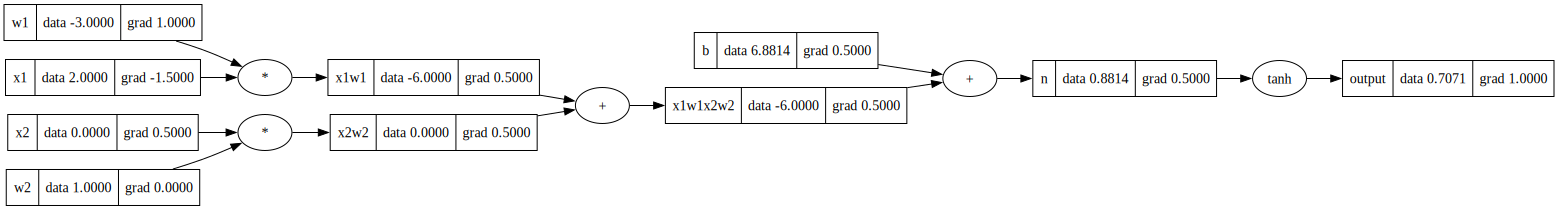

In [17]:
draw_dot(o) #this is what ends up happening inside a neuron
#keep in mind the values of grad that we get here are only for the given values of x2, w2, x1, w1, ie
#for one pass of backprop, what we would do is let this pass happen many times for all the data samples

#also here we see that grad of w2 is 0 that is del L/del w2 is 0 and this is because if we wiggle
#w2 to be any other value, the fact that its multiplied by x2 which has a val of 0 means that
#it wont have any effect no matter what. But x2 has a grad of 0.5 or a non zero value as wiggling 
#x2 will result in a change in the final L as its multiplied by a non zero value(w2)

In [29]:
#writing the params of the neuron again so that this time the backprop can be done using functions
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'

In [19]:
# o.grad = 1

In [20]:

# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# w2._backward()
# x2._backward()
# w1._backward()
# x1._backward()

In [31]:
o.backward_prop()

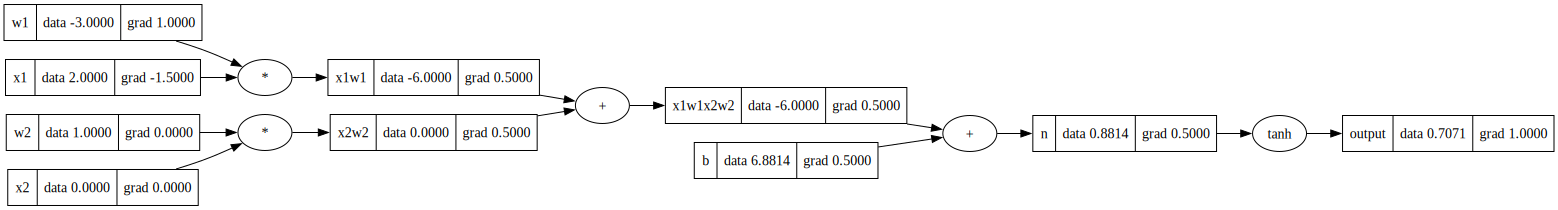

In [33]:
draw_dot(o)

In [22]:
#now to not even manully mention the _backward() function again and again, we can sort
#out the nodes using topological sort, which is a sort of a directed acyclic graph where for every directed
#edge u->v, u appears before v, its used to indicate the dependencies among the items in the graph
# topo = []
# visited = set()

# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for children_v in v._prev:
#             build_topo(children_v)
#         topo.append(v)


In [23]:
# build_topo(o)
# topo
#the root node which represents the final output here is at the end of the topological list, and
#all the dependecies are mentioned before it in order, and the stray leaf nodes are added at the
#very beginning of the list

In [24]:
#now we can just go through a reverse for loop and call the _backwards() function each time to find
#the grad wrt that param
# for node in range(len(topo)-1, -1, -1):
#     topo[node]._backward()

#this works now, and now we can move the topological graph functionality within the class Value

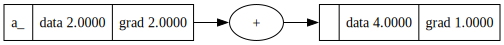

In [26]:
a_ = Value(2.0, label='a_')
b_ = a_ + a_
b_.backward_prop()
draw_dot(b_)
#in this case the gradients deposit itself from the righthandside to the left onto a_, but since b_
#depends on a_ twice, it means that b_ deposits its gradient onto a_ twice, which makes sense, this
#was warranted by the change of += instead of = which increments instead of overrwrite(as the second 
#= statement overrides the first one)

In [ ]:
#doing the same thing but in pytorch